<font color='red'><b>Before launching this notebook, be sure that all data have been loaded by launching all the tiles in data_creation.ipynb.</b></font>

In [1]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy
import json
import torch
import torch.nn as nn
from math import sin, cos, sqrt, atan2, radians
import copy
from sklearn.cluster import *
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import geopy.distance
from scipy.spatial.distance import *
import random
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.neighbors import KDTree
import folium
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import matplotlib
import matplotlib.pyplot as plt


import python.data as data
import python.display as dp
import python.voxels as voxel
import python.metric as metric
import python.clustering as cl
import python.RNN as RNN
#import python.learning as learning
#from python.NN import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


plt.style.use('seaborn-whitegrid')
graph_size = (13,6)

font = {'size'   : 22}

matplotlib.rc('font', **font)





In [2]:
project_folder = "monresovelo"

display = True

clean_routes = True

new_distance_matrix = True

save_dbscan_oservations = True

new_voxels_clustering = True
save_voxels_clustering = True

# Data Loading

In [3]:
with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'rb') as infile:
    df_simplified = pickle.load(infile)
tab_routes_voxels_simplified, tab_routes_voxels_simplified_global, dict_voxels_simplified = voxel.generate_voxels(
    df_simplified, df_simplified.iloc[0]["route_num"], df_simplified.iloc[-1]["route_num"])
df_simplified = df_simplified[["lat", "lon", "route_num"]]

In [4]:
with open("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'rb') as infile:
    df_pathfinding = pickle.load(infile)
tab_routes_voxels_pathfinding, tab_routes_voxels_pathfinding_global, dict_voxels_pathfinding = voxel.generate_voxels(
    df_pathfinding, df_pathfinding.iloc[0]["route_num"], df_pathfinding.iloc[-1]["route_num"])


# Voxels' demonstration

This tile is a graphical demonstration of the voxels, it shows all the voxels created for one observation.

In [9]:
map=None
if(display):
    num_vox = -1
    tab_vox = []
    num_route = 0
    df_display = df_simplified[df_simplified["route_num"]==num_route]
    df_display["type"] = 0
    for v in tab_routes_voxels_simplified[num_route]:
        vox_str = v.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_vox += voxel.get_voxel_points(vox_int, num_vox)
        num_vox -= 1

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, 13, color="type")
map

This tile shows the voxels on the common part between 2 observations.

In [10]:
if(display):
    min_routes = 2
    df_simplified["type"] = 0
    df_display = df_simplified[(df_simplified["route_num"]==0)]
    df_temp = df_simplified[(df_simplified["route_num"]==4)]
    df_display["route_num"] = 0
    df_temp["route_num"] = 1
    df_display = df_display.append(df_temp)
    #print(df_display)
    _, _, dict_voxels = voxel.generate_voxels(df_display, 0, 1)
    tab_vox = voxel.get_voxels_with_min_routes(dict_voxels, min_routes)

    df = pd.DataFrame(tab_vox, columns=["lat", "lon", "route_num", "type"])
    df_display = df_display.append(df)
    map = dp.display(df_display, color="type") 
    #print(tab_vox)
    #print(df)
    data.check_file("files/"+project_folder+"/images/similarity_metric.html")
    map.save("files/"+project_folder+"/images/similarity_metric.html")
    
map

# Heat Maps

Heat map using the cyclability coefficient of the voxels created with the observations (see our paper for more information).

In [11]:
if(display):     
    tab = []
    for key in dict_voxels_simplified:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_simplified[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], zoom_start=11,tiles = 'Stamen Toner')
    HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    map.save("files/"+project_folder+"/images/heatmap_experienced.html")

    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_simplified.png")'''
map

/tmp/ipykernel_17929/2027760347.py:12: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=df.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)


Heat map using the cyclability coefficient of the voxels created with the osmnx shortest paths (see our paper for more information).

In [12]:
if(display):
    tab = []
    for key in dict_voxels_pathfinding:
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        vox_pos = voxel.get_voxel_points(vox_int, 0)
        tab.append([vox_pos[0][0], vox_pos[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])

    df = pd.DataFrame(tab, columns=["lat", "lon", "Cyclability coefficient"])
    
    map = folium.Map(location=[df.iloc[0]["lat"],df.iloc[0]["lon"]], control_scale=True, zoom_start=11, tiles = 'Stamen Toner')
    HeatMap(data=df[['lat', 'lon', 'Cyclability coefficient']].values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
    
    map.save("files/"+project_folder+"/images/heatmap_computed.html")

    
    '''fig = px.scatter_mapbox(df, lat="lat", lon="lon",  color="Cyclability coefficient", size="Cyclability coefficient", zoom=11)
    fig.show()
    fig.write_image("images/heatmap_mapbox.png")'''

map

/tmp/ipykernel_17929/1066062304.py:12: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=df[['lat', 'lon', 'Cyclability coefficient']].values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)


# Distances

4881


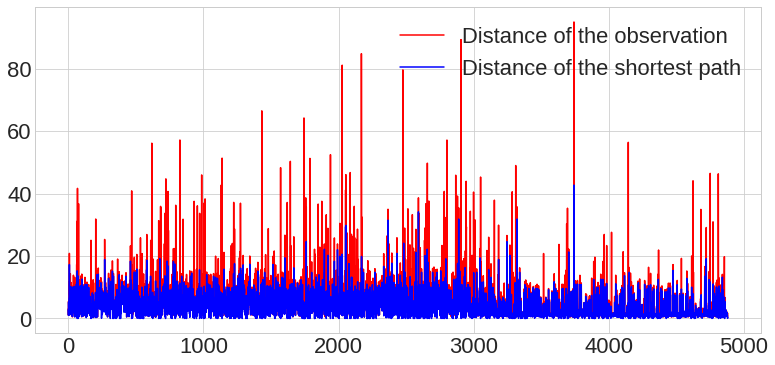

In [13]:
if(display):
    with open("files/"+project_folder+"/distances/distances_observations.tab",'rb') as infile:
        tab_distances = pickle.load(infile)    

    with open("files/"+project_folder+"/distances/distances_osmnx.tab",'rb') as infile:
        tab_distances_pf = pickle.load(infile)   

    print(len(tab_distances_pf))
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_pf), len(tab_distances_pf))
    plt.plot(x, tab_distances, color='red', label='Distance of the observation')
    plt.plot(x, tab_distances_pf, color='blue', label='Distance of the shortest path')
    
    plt.legend(loc='upper right')

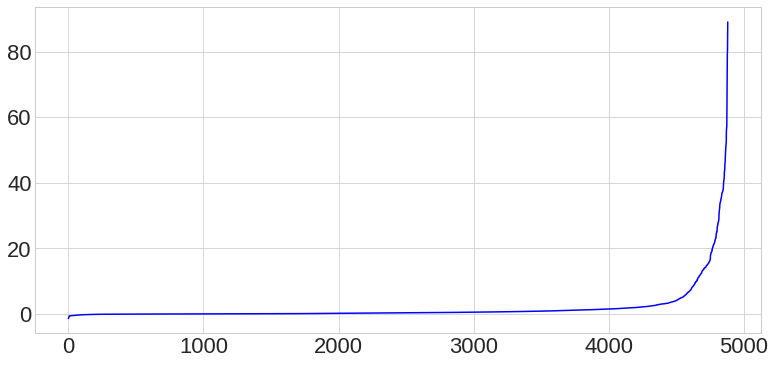

In [14]:
if(display):
    tab_distances_relatives = []
    for i in range(len(tab_distances)):
        tab_distances_relatives.append(tab_distances[i]-tab_distances_pf[i])
    tab_distances_pcf = deepcopy(tab_distances_relatives)
    tab_distances_pcf.sort()
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.linspace(0, len(tab_distances_pcf), len(tab_distances_pcf))
    plt.plot(x, tab_distances_pcf, color='blue')
    plt.savefig("files/"+project_folder+"/images/distances_relatives_sorted.png")

In [15]:
tab_neg = []
for i in range(len(tab_distances_relatives)):
    if(tab_distances_relatives[i]<0):
        tab_neg.append(i)
print(len(tab_neg)/len(tab_distances_relatives)*100, "% of negative detours")

12.661339889366932 % of negative detours


# CDF

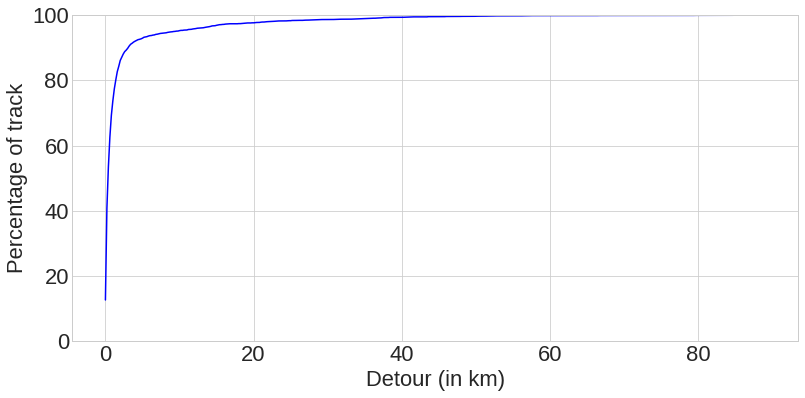

In [16]:
if(display):
    tab_display = []
    tab_axis = []
    dist_max = 0
    nb_routes = 0
    for dist in tab_distances_pcf:
        while(dist > dist_max):
            tab_display.append(nb_routes/len(tab_distances_pcf)*100)
            tab_axis.append(dist_max)
            dist_max += 0.2
        nb_routes += 1
        
        
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    plt.ylim(0,100)
    plt.plot(tab_axis, tab_display, color='blue')
    plt.ylabel('Percentage of track')
    plt.xlabel('Detour (in km)')
    plt.savefig("files/"+project_folder+"/images/cdf.png")

# Deletion of bad routes

This part deletes the observations and the affiliated shortest paths and mapbox routes for 2 types of problems : 1) when the observations makes a detour > 2.5km compared to the shortest path and 2) when no shortest path has been found.

In [17]:
tab_num_bad_route = []
for i in range(len(tab_distances_relatives)):
    if(tab_distances_relatives[i]>= 2.5):
        #print(i)
        tab_num_bad_route.append(i)
print(len(tab_num_bad_route), "observation(s) having a detour >= 2.5km")

tab_num_bad_sp = []
for i in range(df_pathfinding.iloc[-1]["route_num"]):
    df_temp = df_pathfinding[df_pathfinding["route_num"]==i]
    if(len(df_temp) == 1):
        if i not in tab_num_bad_route:
            tab_num_bad_sp.append(i)
            
tab_num_bad_route += tab_num_bad_sp
print(len(tab_num_bad_sp), "empty shortest path.")
print(len(tab_num_bad_route), "route(s) to delete.")

565 observation(s) having a detour >= 2.5km
44 empty shortest path.
609 route(s) to delete.


In [18]:
with open("files/"+project_folder+"/data_processed/mapbox_pathfinding_simplified.df",'rb') as infile:
    df_mapbox = pickle.load(infile)

num_last_route=df_simplified.iloc[-1]["route_num"]
print(num_last_route, "routes before cleaning.")
df_simplified_saved = deepcopy(df_simplified)
df_pathfinding_saved = deepcopy(df_pathfinding)
df_mapbox_saved = deepcopy(df_mapbox)
if(num_last_route==df_pathfinding.iloc[-1]["route_num"] and len(tab_num_bad_route) > 0 and clean_routes):
    for num_bad_route in tab_num_bad_route:
        df_simplified = df_simplified[df_simplified["route_num"] != num_bad_route]
        df_pathfinding = df_pathfinding[df_pathfinding["route_num"] != num_bad_route]
        df_mapbox = df_mapbox[df_mapbox["route_num"] != num_bad_route]
        
    df_simplified = data.clean_dataframe(df_simplified)
    df_pathfinding = data.clean_dataframe(df_pathfinding)
    df_mapbox = data.clean_dataframe(df_mapbox)
    
    
    if(df_simplified.iloc[-1]["route_num"] != df_pathfinding.iloc[-1]["route_num"] or
       df_simplified.iloc[-1]["route_num"] != df_mapbox.iloc[-1]["route_num"] or
       df_pathfinding.iloc[-1]["route_num"] != num_last_route-len(tab_num_bad_route)):
        raise ValueError('Cleaning dataframe did not work')
    
    with open("files/"+project_folder+"/data_processed/observations_matched_simplified.df",'wb') as outfile:
        pickle.dump(df_simplified, outfile)
    with open("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df",'wb') as outfile:
        pickle.dump(df_pathfinding, outfile)
    with open("files/"+project_folder+"/data_processed/mapbox_pathfinding_simplified.df",'wb') as outfile:
        pickle.dump(df_mapbox, outfile)
    data.compute_distance("files/"+project_folder+"/data_processed/observations_matched_simplified.df",
                      "files/"+project_folder+"/distances/distances_observations.tab")
    data.compute_distance("files/"+project_folder+"/data_processed/osmnx_pathfinding_simplified.df", 
                          "files/"+project_folder+"/distances/distances_osmnx.tab")
    
    with open("files/"+project_folder+"/distances/distances_observations.tab",'rb') as infile:
        tab_distances = pickle.load(infile)    
    with open("files/"+project_folder+"/distances/distances_osmnx.tab",'rb') as infile:
        tab_distances_pf = pickle.load(infile) 
    tab_distances_relatives = []
    for i in range(len(tab_distances)):
        tab_distances_relatives.append(tab_distances[i]-tab_distances_pf[i])
    
        
    tab_routes_voxels_simplified, tab_routes_voxels_simplified_global, dict_voxels_simplified = voxel.generate_voxels(df_simplified, df_simplified.iloc[0]["route_num"], df_simplified.iloc[-1]["route_num"])
    tab_routes_voxels_pathfinding, tab_routes_voxels_pathfinding_global, dict_voxels_pathfinding = voxel.generate_voxels(df_pathfinding, df_pathfinding.iloc[0]["route_num"], df_pathfinding.iloc[-1]["route_num"])
print(df_simplified.iloc[-1]["route_num"], "routes after cleaning.")    

4880 routes before cleaning.
4880 4880 True True
Cleaning dataframe...
Cleaning dataframe...
Cleaning dataframe...
Calculating the distance of route 4271/4271.
Calculating the distance of route 4271/4271.
4271 routes after cleaning.


# Distance matrix

Creation of the distance matrix to give to dbscan for the clustering. The distance between the the observatiosn are computed using the voxels (see our paper).

In [19]:
if(new_distance_matrix):
    distance_matrix = np.empty([df_simplified.iloc[-1]["route_num"]+1, df_simplified.iloc[-1]["route_num"]+1])

    pca = PCA(n_components=1)

    for i in range(df_simplified.iloc[-1]["route_num"]+1):

        for j in range(i, df_simplified.iloc[-1]["route_num"]+1):
            coeff = metric.get_distance_voxels(i, j, tab_routes_voxels_simplified_global)
            #coeff = metric.get_distance_euclidian(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1], pca)
            #coeff = metric.get_distance_hausdorff(df_cluster[df_cluster["route_num"]==i+1], df_cluster[df_cluster["route_num"]==j+1])
            distance_matrix[i][j] = coeff[0]
            distance_matrix[j][i] = coeff[1]
    
    data.check_file("files/"+project_folder+"/clustering/distances_dbscan.mx", [])
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'wb') as outfile:
        pickle.dump(distance_matrix, outfile)
    
else:
    with open("files/"+project_folder+"/clustering/distances_dbscan.mx",'rb') as infile:
        distance_matrix = pickle.load(infile)

print("number of non-zero in diag : ", len(np.nonzero(np.diagonal(distance_matrix))[0]))

number of non-zero in diag :  0


# Clustering configuration

In [20]:
config_clustering = {"eps": 0.5, "min_samples": 3, "n_clusters_divider": 15}

# Clustering graphs

In [21]:
start_variable = 0.1
stop_variable = 1
step_variable = 0.1

tab_nb_clusters = []
tab_noise = []
tab_nb_mini_clusters = []
tab_nb_big_clusters = []
tab_mean = []
tab_silhouette = []

for variable in np.arange(start_variable, stop_variable, step_variable):
    c = DBSCAN(eps=variable, min_samples=config_clustering["min_samples"], metric='precomputed')
    clusters = cl.cluster(distance_matrix, c)
    dict_cluster = cl.tab_clusters_to_dict(clusters)
    silhouette = silhouette_score(distance_matrix, clusters, metric="precomputed")

    nb_mini_clusters= 0
    nb_big_clusters = 0
    mean = 0
    for i in range(len(dict_cluster)-1): 
        if(len(dict_cluster[i]) >= len(distance_matrix)*2/100):
            nb_big_clusters += 1
        elif(len(dict_cluster[i]) <= len(distance_matrix)*0.1/100):
            nb_mini_clusters += 1
        mean+=len(dict_cluster[i])
        
    tab_nb_clusters.append(len(dict_cluster)-1)
    tab_noise.append(clusters.tolist().count(-1))
    tab_nb_mini_clusters.append(nb_mini_clusters)
    tab_nb_big_clusters.append(nb_big_clusters)
    tab_mean.append(mean/(len(dict_cluster)-1))
    tab_silhouette.append(silhouette)
    


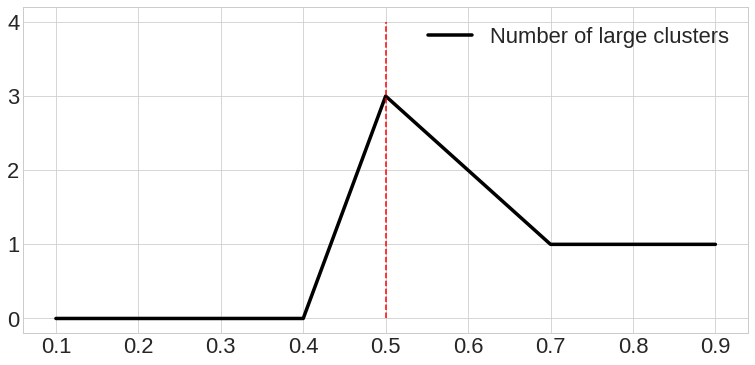

In [22]:
if(display):    
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    #plt.plot(x, tab_nb_mini_clusters, color='red', linewidth=3.5, label='Mini clusters')
    plt.plot(x, tab_nb_big_clusters, color='black', linewidth=3.5, label='Number of large clusters')  
    plt.legend(loc='upper right')
    plt.vlines(config_clustering["eps"], 0, max(tab_nb_big_clusters)+1, linestyles ="dashed", colors ="red")
    plt.savefig("files/"+project_folder+"/images/nb_large_clusters.png")

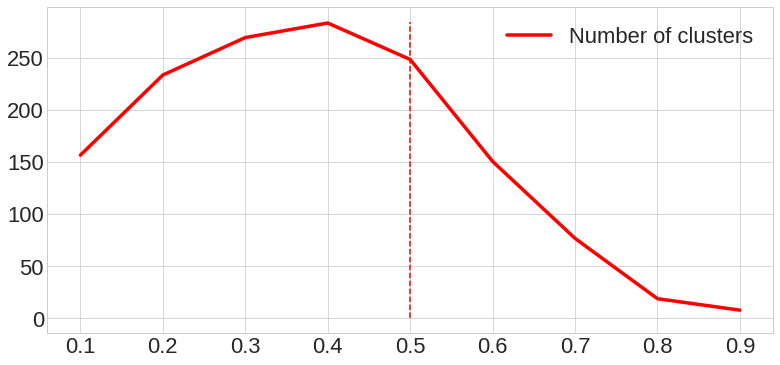

In [23]:
if(display):
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_nb_clusters, color='red', linewidth=3.5, label="Number of clusters")
    plt.legend(loc='upper right')
    data.check_file("files/"+project_folder+"/images/nb_clusters.png", [])
    plt.vlines(config_clustering["eps"], 0, max(tab_nb_clusters)+1, linestyles ="dashed", colors ="red")
    plt.savefig("files/"+project_folder+"/images/nb_clusters.png")

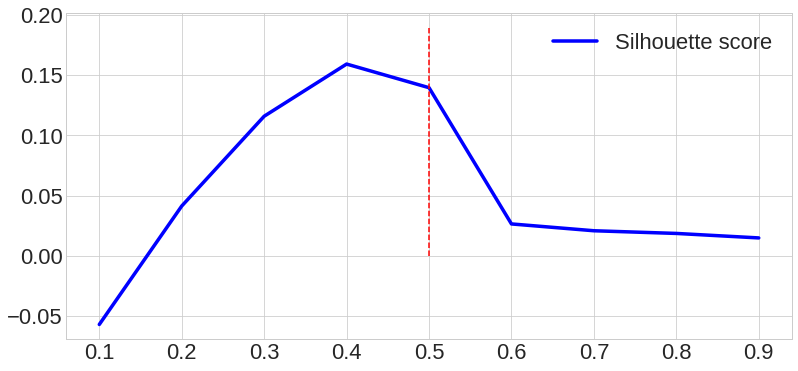

In [24]:
if(display):  
    
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_silhouette, color='blue', linewidth=3.5, label="Silhouette score")
    plt.legend(loc='upper right')
    plt.vlines(config_clustering["eps"], 0, max(tab_silhouette)+0.03, linestyles ="dashed", colors ="red")
    plt.savefig("files/"+project_folder+"/images/silhouette.png")

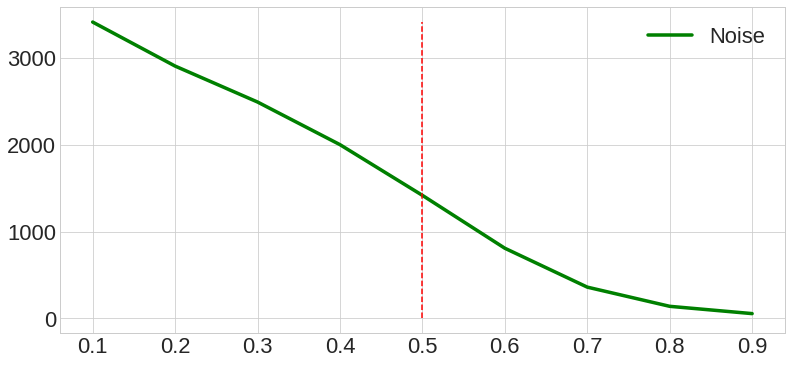

In [25]:
if(display):   
    fig = plt.figure(figsize=graph_size)
    ax = plt.axes()
    x = np.arange(start_variable, stop_variable, step_variable)
    plt.plot(x, tab_noise, color='green', linewidth=3.5, label="Noise")
    plt.legend(loc='upper right')
    plt.vlines(config_clustering["eps"], 0, max(tab_noise)+1, linestyles ="dashed", colors ="red")
    plt.savefig("files/"+project_folder+"/images/noise.png")

# Observations Clustering

In [26]:
pca = PCA(n_components=750)
#distance_matrix_reduced = pca.fit_transform(distance_matrix)

dbscan = DBSCAN(eps=config_clustering["eps"], min_samples=config_clustering["min_samples"], metric='precomputed')
optics = OPTICS(min_samples=10, metric='precomputed')

clustering = dbscan
X = distance_matrix

tab_cluster = cl.cluster(X, clustering)
dict_cluster = cl.tab_clusters_to_dict(tab_cluster)

print(len(dict_cluster)-1, "clusters")
print("noise:", tab_cluster.tolist().count(-1))
print()
cl.cluster_properties(dict_cluster, distance_matrix, tab_cluster, "precomputed")

249 clusters
noise: 1418

silhouette score : 0.13964713602770393

mean size : 11.461847389558233

3 big clusters: [2, 15, 25]
196 mini clusters : [7, 3, 8, 9, 12, 211, 16, 17, 19, 20, 21, 23, 26, 27, 28, 29, 56, 31, 190, 37, 34, 35, 141, 36, 39, 40, 44, 46, 48, 49, 51, 52, 53, 54, 55, 58, 59, 219, 61, 62, 66, 69, 70, 71, 72, 73, 74, 75, 215, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 142, 101, 93, 94, 95, 96, 97, 98, 99, 100, 228, 102, 103, 104, 208, 106, 107, 109, 205, 110, 111, 139, 112, 122, 239, 213, 115, 116, 119, 120, 121, 207, 123, 124, 125, 127, 128, 130, 131, 133, 134, 135, 136, 137, 138, 140, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 166, 168, 169, 171, 172, 192, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 210, 189, 230, 193, 194, 195, 196, 197, 198, 238, 199, 200, 201, 202, 203, 204, 206, 242, 209, 212, 214, 216, 217, 220, 221, 227, 222, 224, 225, 240, 229, 231, 

In [27]:
if(save_dbscan_oservations):
    print("Saving DBSCAN observations...")
    with open("files/"+project_folder+"/clustering/dbscan_observations.dict",'wb') as outfile:
        pickle.dump(dict_cluster, outfile)
    with open("files/"+project_folder+"/clustering/dbscan_observations.tab",'wb') as outfile:
        pickle.dump(tab_cluster, outfile)
else:
    print("DBSCAN not saved, see the second tiles to change save_dbscan_oservations.")

Saving DBSCAN observations...


Heat map of one cluster created by DBSCAN.


In [28]:
if(display):
    num_cluster = 9
    print(len(dict_cluster[num_cluster]))
    map = dp.display_cluster_heatmap(df_pathfinding, dict_cluster[num_cluster])
    map.save("files/"+project_folder+"/images/heatmap_larg_clust_computed.html")
    map = dp.display_cluster_heatmap(df_simplified, dict_cluster[num_cluster])
    map.save("files/"+project_folder+"/images/heatmap_larg_clust_experienced.html")
map

6


/home/lucas/Projets/repo_paper/python/display.py:108: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=dfdisplay.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)
/home/lucas/Projets/repo_paper/python/display.py:108: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data=dfdisplay.values.tolist(), max_zoom=13, radius=9, blur = 1, min_opacity = 0, max_val = 1).add_to(map)


# Voxel Clustering

This part clusters the voxels with kmeans in order to help the LSTM convergence (see our paper for more explanations).

In [29]:
X = []
for key in dict_voxels_pathfinding:
    if("cluster" not in dict_voxels_pathfinding[key]):
        vox_str = key.split(";")
        vox_int = [int(vox_str[0]), int(vox_str[1])]
        tab_points = voxel.get_voxel_points(vox_int)
        X.append([tab_points[0][0], tab_points[0][1], dict_voxels_pathfinding[key]["cyclability_coeff"]])
print(len(X))

44318


In [30]:
if(new_voxels_clustering):  
    kmeans = KMeans(n_clusters=len(X)//config_clustering["n_clusters_divider"], random_state=0)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = cl.cluster(X, kmeans)

else:
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'rb') as infile:
        kmeans = pickle.load(infile)
    clusters = kmeans.labels_
        
dict_cluster_voxel = cl.tab_clusters_to_dict(clusters)

cl.cluster_properties(dict_cluster_voxel, X, clusters)
print(len(dict_cluster_voxel)-1, "clusters")
print("noise:", clusters.tolist().count(-1))
print()


silhouette score : 0.4408513590335365

mean size : 15.007788689468338

0 big clusters: []
2954 mini clusters : [2146, 1935, 1162, 1040, 1999, 2514, 171, 888, 610, 1893, 2756, 1600, 2302, 1601, 2293, 1870, 1488, 1602, 2320, 693, 2196, 1787, 488, 463, 1467, 2704, 1110, 1587, 1280, 2227, 670, 2866, 1639, 2008, 2550, 752, 718, 1213, 2658, 149, 553, 2940, 539, 1983, 361, 2775, 313, 2135, 838, 2485, 1921, 2512, 2856, 1283, 1898, 354, 2040, 2190, 75, 1737, 1204, 2619, 2, 1802, 805, 2398, 1988, 2816, 1018, 2534, 1406, 2559, 1313, 2551, 2542, 877, 1663, 2158, 2220, 1760, 397, 2936, 1705, 772, 1447, 2506, 1043, 144, 1543, 234, 1424, 1717, 2173, 413, 2168, 2873, 443, 1293, 308, 1134, 12, 2072, 2477, 1838, 1409, 504, 1756, 778, 2934, 727, 2333, 61, 573, 92, 105, 2259, 1322, 192, 1181, 754, 1382, 2859, 2564, 1970, 1441, 2664, 2043, 1307, 2434, 2162, 1355, 2516, 2449, 434, 138, 1156, 290, 1082, 2419, 2336, 864, 283, 1479, 1664, 2894, 215, 1925, 702, 1609, 2380, 2538, 518, 1320, 870, 2510, 761, 427, 

In [31]:
if(save_voxels_clustering):
    print("Saving kmeans_voxels_osmnx.sk...")
    with open("files/"+project_folder+"/clustering/kmeans_voxels_osmnx.sk",'wb') as outfile:
        pickle.dump(kmeans, outfile)

Saving kmeans_voxels_osmnx.sk...


In [32]:
dict_voxels_pathfinding_clustered = deepcopy(dict_voxels_pathfinding)
for c in dict_cluster_voxel:
    for vox in dict_cluster_voxel[c]:
        v = X[vox]
        vox_int = voxel.find_voxel_int([v[0], v[1]], False)
        key = str(vox_int[0])+";"+str(vox_int[1])
        dict_voxels_pathfinding_clustered[key]["cluster"] = c #len(clusters_used)+c
if(save_voxels_clustering):
    print("Saving voxels_clustered_osmnx.dict...")
    with open("files/"+project_folder+"/clustering/voxels_clustered_osmnx.dict",'wb') as outfile:
        pickle.dump(dict_voxels_pathfinding_clustered, outfile)
else:
    print("Voxels' clustering have not been saved, check the second tiles to change save_voxels_clustering.") 

Saving voxels_clustered_osmnx.dict...


<b>When clusters have been saved, you can run python/main_NN.py to train an LSTM.</b>